In [1]:
import sys
sys.path.insert(1, "../")  

import numpy as np
import pandas as pd
import tensorflow as tf
np.random.seed(0)
import aif360
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric, Metric
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import StructuredDataset
from aif360.datasets import StandardDataset
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from aif360.algorithms.preprocessing import DisparateImpactRemover
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from sklearn.model_selection import train_test_split
from IPython.display import Markdown, display
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import f_oneway
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools

C:\Users\danie\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\danie\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\danie\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
pip install 'aif360[LawSchoolGPA]'


In [2]:
df=pd.read_csv("C:/Users/danie/OneDrive/Desktop/diabetic_data.csv")
df.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
# Le variabili admission_type_id, discharge disposition id, admission source id hanno un corrispondente mapping,
# che tuttavia non è mostrato. Quindi farci delle analisi è un po' inutile.

In [4]:
#visualizzo le features di questo dataset
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

Vediamo di capire la distribuzione che c'è tra il sesso e la race, vedendo chi ha subito il maggior cambiamento di terapia.

## Distribuzione di A1Cresult

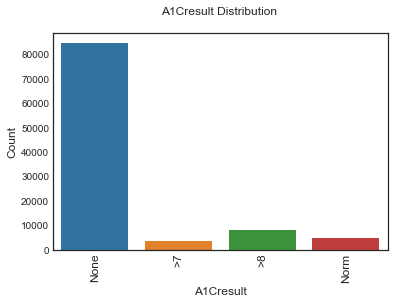

In [5]:
ax = sns.countplot(x='A1Cresult',   data= df)
plt.xlabel('A1Cresult', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('A1Cresult Distribution \n', size = 12)
plt.show()

In [6]:
# None indica che il test per l'emoglobina glicata non è stato sostenuto

## Distribuzione Medical Speciality

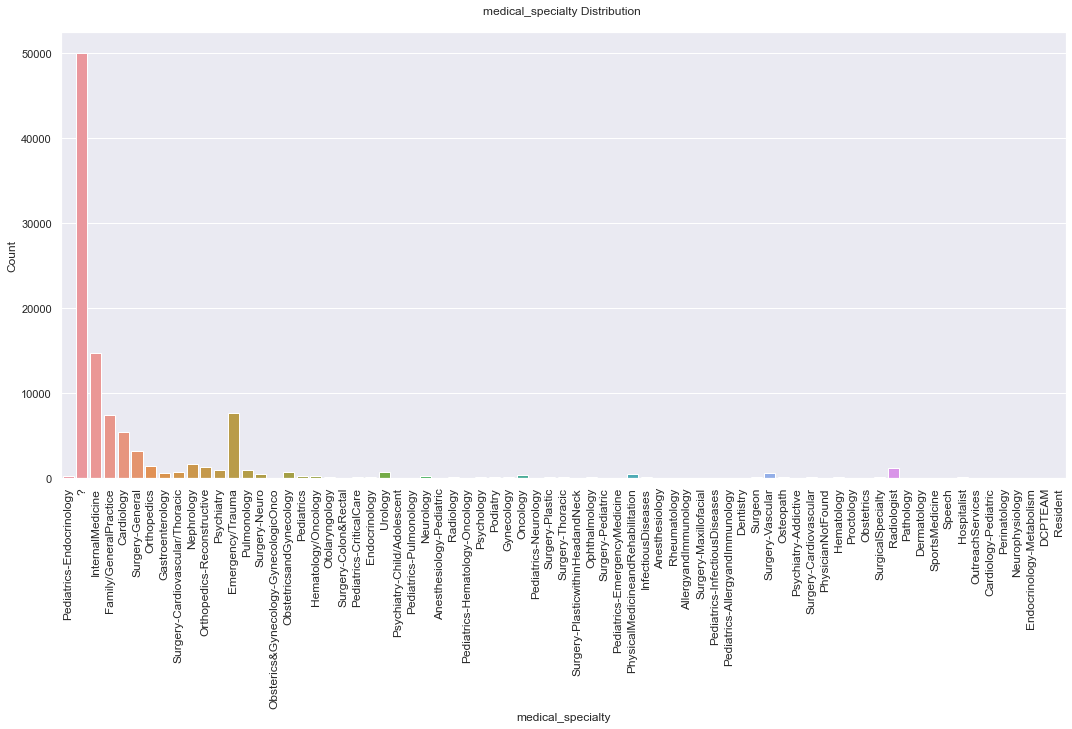

In [7]:
sns.set(rc={'figure.figsize':(18,8.2)})
ax = sns.countplot(x='medical_specialty',   data= df)
plt.xlabel('medical_specialty', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('medical_specialty Distribution \n', size = 12)
plt.show()

## Distribuzione Diagnosis

## Distribuzione Num Lab Procedures

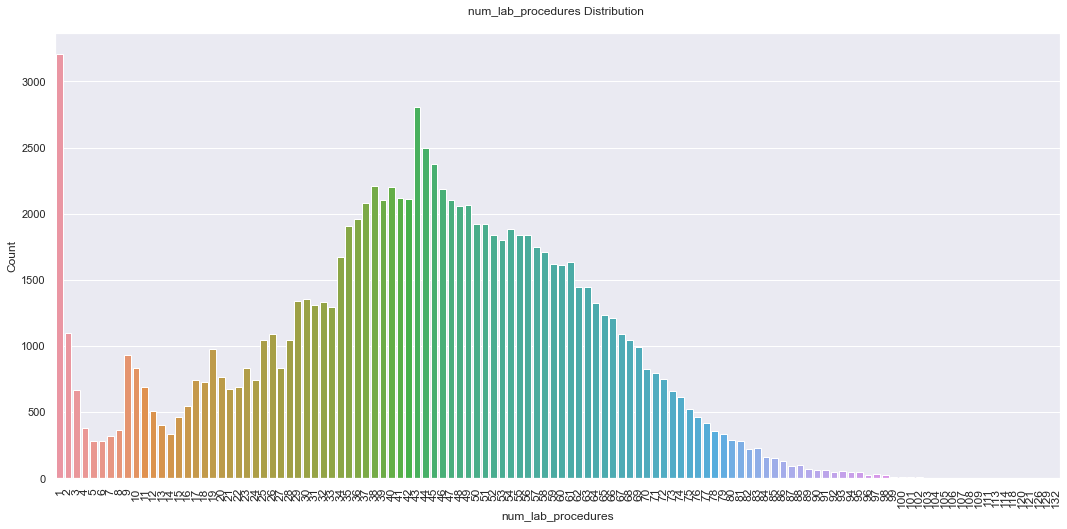

In [8]:
ax = sns.countplot(x='num_lab_procedures',   data= df)
plt.xlabel('num_lab_procedures', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('num_lab_procedures Distribution \n', size = 12)
plt.show()

Il dataset contiene più di una occorrenza per ciascuna visita effettuata su un paziente ricoverato. Considero quindi solo la prima visita per ciascun paziente come primary admission e determino basandomi su questo, se il paziente viene poi riammesso o meno entro 30 giorni. Questo lo faccio per tenere un certo grado di indipendenza tra le varie tuple.

In [9]:
df=df.drop_duplicates(subset=['patient_nbr'],keep='first')

Rimuovo anche quei risultati che si sono conclusi o con la morte del paziente oppure con la sua dimissione presso un ospizio. Questo viene fatto per evitare l'insorgenza di bias durante l'analisi. 

## Null Values

In [10]:
for i in df.columns:
    print(i, df[df[i] == '?'].shape[0])

encounter_id 0
patient_nbr 0
race 1948
gender 0
age 0
weight 68665
admission_type_id 0
discharge_disposition_id 0
admission_source_id 0
time_in_hospital 0
payer_code 31043
medical_specialty 34477
num_lab_procedures 0
num_procedures 0
num_medications 0
number_outpatient 0
number_emergency 0
number_inpatient 0
diag_1 11
diag_2 294
diag_3 1225
number_diagnoses 0
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0


Weights had 97% of valus null. So we drop the column

Siccome la quantità di race e delle diagnosi è bassa, droppiamo queste righe

In [11]:
df = df[df["race"] != '?']
df = df[df["diag_1"] != '?']
df = df[df["diag_2"] != '?']
df = df[df["diag_3"] != '?']

Per payer code e medical spaciality, si possono seguire due vie. La prima è quella di rimuovere le colonne, la seconda è quella di sostituire il valore con la moda. Oppure possiamo creare un modello e metterlo dentro.

In [12]:
df1=df.drop(['payer_code','medical_specialty','weight'], axis=1)

In [13]:
df1.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,No,Steady,No,No,No,No,No,No,Yes,>30


Questo conclude la parte di cleaning. Passiamo ora ad analizzare l'outcome. 

In [14]:
df1['readmitted'].value_counts()

NO     40729
>30    21539
<30     6090
Name: readmitted, dtype: int64

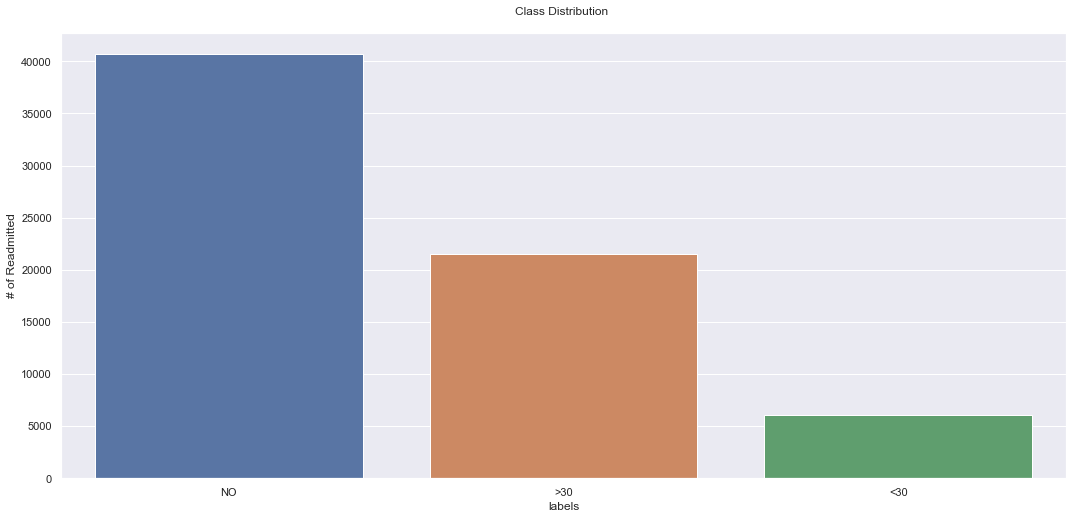

In [15]:
ax = sns.barplot(x=df1['readmitted'].value_counts().index,   y=df1['readmitted'].value_counts())
plt.xlabel('labels', size = 12)
plt.ylabel('# of Readmitted', size = 12)
plt.title('Class Distribution \n', size = 12)
plt.show()

Come vediamo dall'analisi, la maggior parte degli outcome consistono di pazienti che non hanno un record di riammissione all'interno dell'ospedale, circa 22000 pazienti sono stati riammessi dopo un periodo superiore ai 30 giorni, e poco più di 5000 sono stati riammessi sotto i 30 giorni. Una cosa interessante sarebbe capire se per esempio ci sia delle discriminazione verso la razza, ossia se magari quelli ad essere stati riammessi siano piu neri che bianchi, oppure se ci sia una discriminazione verso il sesso.

Per chiarezza, andiamo a capire solo se il paziente è stato riammesso oppure no, trasformando quindi l'outcome in una variabile binaria: 1 se non è stato riammesso, 0 se lo è stato

In [16]:
df1['readmitted'].replace(['>30','<30','NO'],[0,0,1],inplace=True)
df1.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,1
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,1
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,1
5,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,No,Steady,No,No,No,No,No,No,Yes,0


In [17]:
#df1['readmitted'].unique()

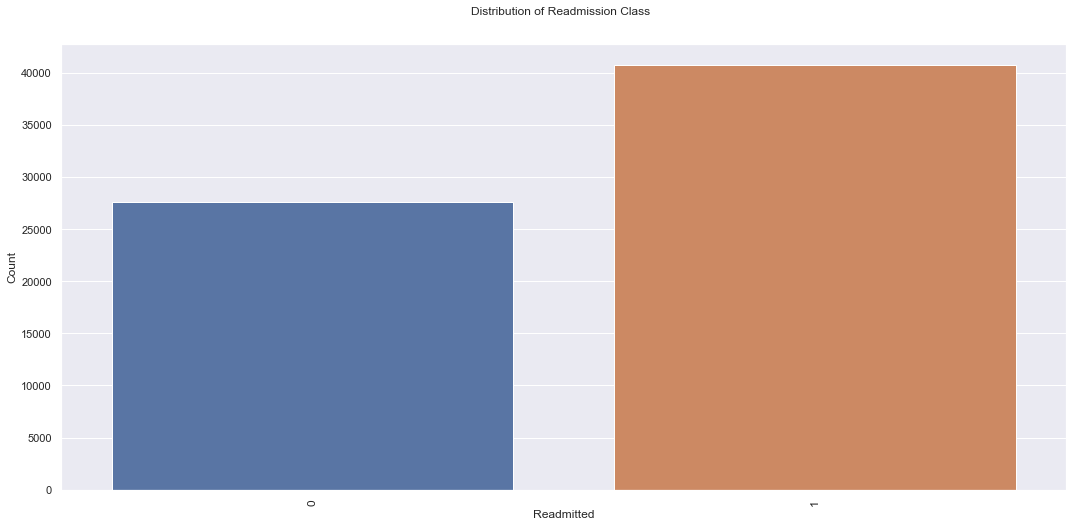

In [18]:
ax = sns.countplot(x='readmitted',   data= df1)
plt.xlabel('Readmitted', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution of Readmission Class  \n\n', size = 12)
plt.show()

We see now the race

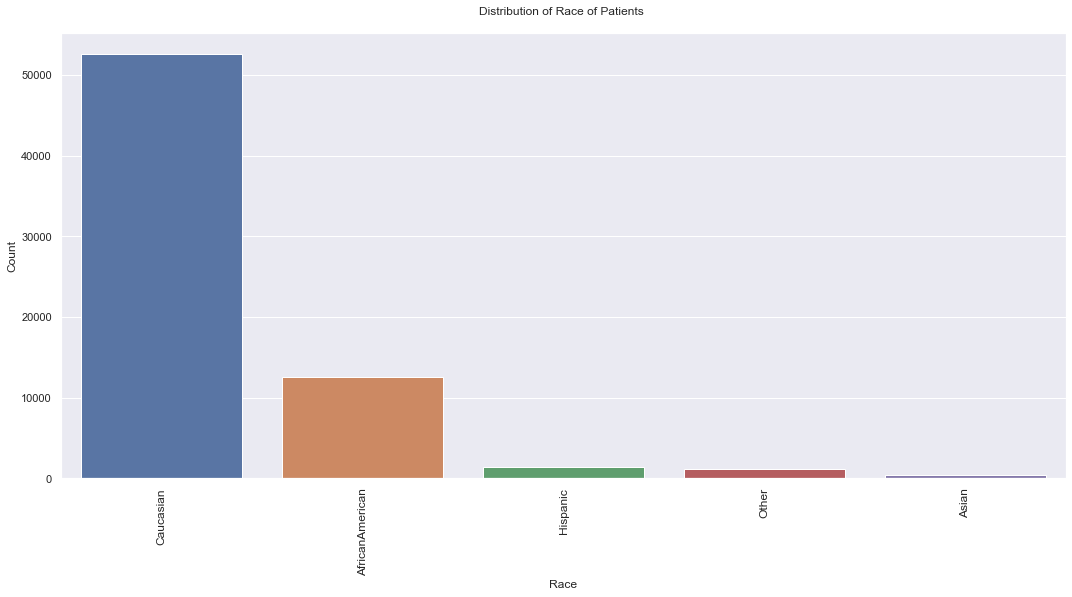

In [19]:
ax = sns.barplot(x=df1['race'].value_counts().index,   y=df1['race'].value_counts())
plt.xlabel('Race', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution of Race of Patients \n', size = 12)
plt.show()

Dalla distribuzione vediamo come la maggior parte delle persone all'interno del dataset sia di razza caucasica.

Vediamo a sto punto la distribuzione del sesso

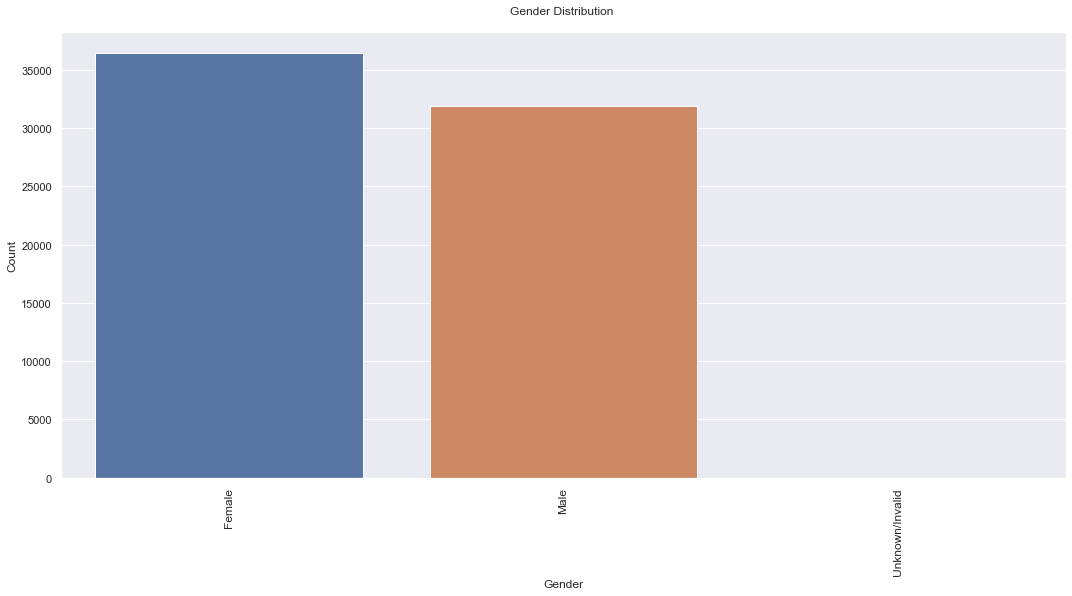

In [20]:
ax = sns.countplot(x='gender',   data= df1)
plt.xlabel('Gender', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Gender Distribution \n', size = 12)
plt.show()

In [21]:
df1.drop(df1[df1['gender'] == 'Unknown/Invalid'].index, inplace = True)

In [22]:
df1.reset_index(inplace = True, drop = True)

In [23]:
df1.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,0
1,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,1
2,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,1
3,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,1
4,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,No,Steady,No,No,No,No,No,No,Yes,0


# Density

Change vs race

race    AfricanAmerican  Asian  Caucasian  Hispanic  Other
change                                                    
Ch                 5672    191      23440       689    583
No                 6939    292      29198       780    573


Text(0, 0.5, 'Count')

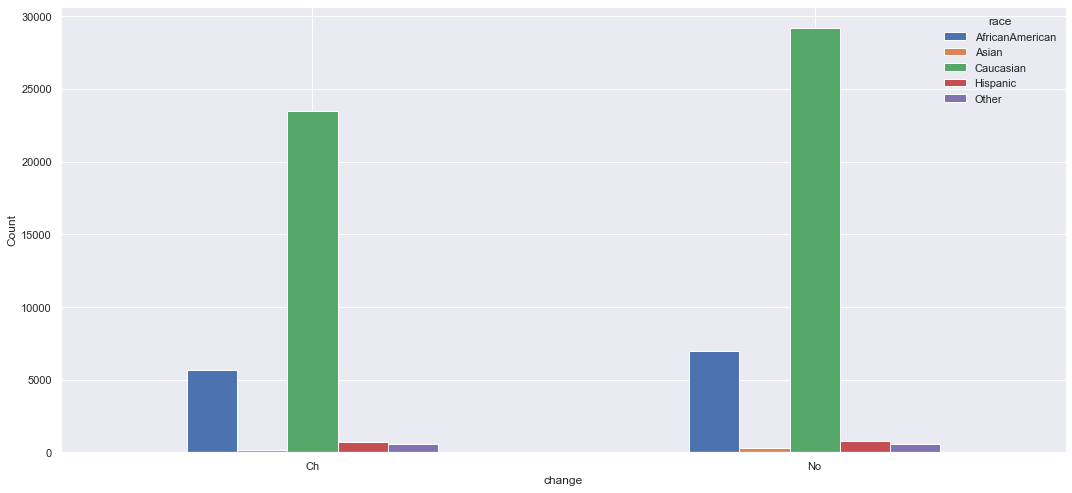

In [24]:
cont=pd.crosstab(df1["change"], df1["race"])
print(cont)
barplot = cont.plot.bar(rot=0)
plt.ylabel("Count")

In [25]:
from scipy.stats import chi2_contingency
ChiSqResult = chi2_contingency(cont)
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

The P-Value of the ChiSq Test is: 6.575975481768658e-05


gender  Female   Male
change               
Ch       15980  14595
No       20460  17322
The P-Value of the ChiSq Test is: 9.0440289173368e-07


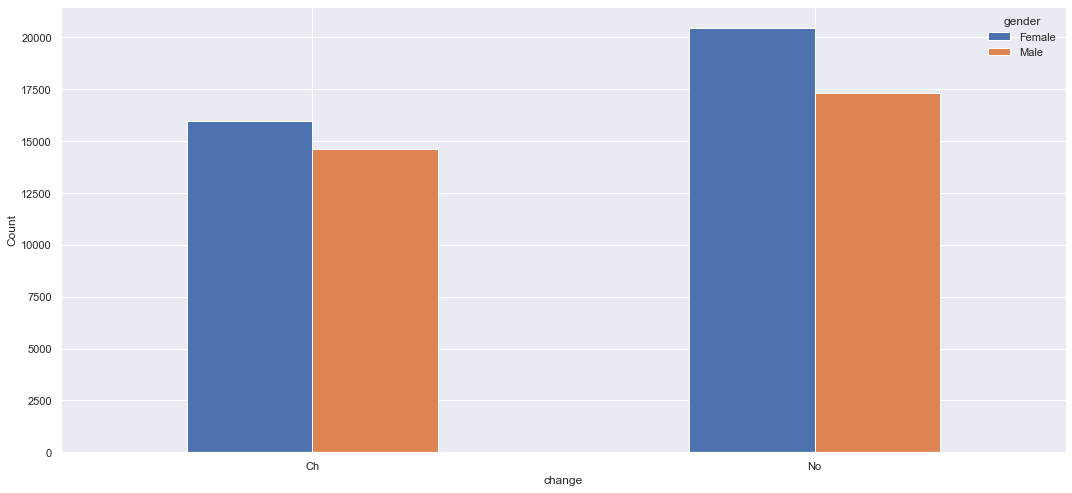

In [26]:
cont=pd.crosstab(df1["change"], df1["gender"])
print(cont)
barplot = cont.plot.bar(rot=0)
plt.ylabel("Count")
ChiSqResult = chi2_contingency(cont)
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

race         AfricanAmerican  Asian  Caucasian  Hispanic  Other
diabetesMed                                                    
No                      3008    130      12808       371    252
Yes                     9603    353      39830      1098    904


Text(0, 0.5, 'Count')

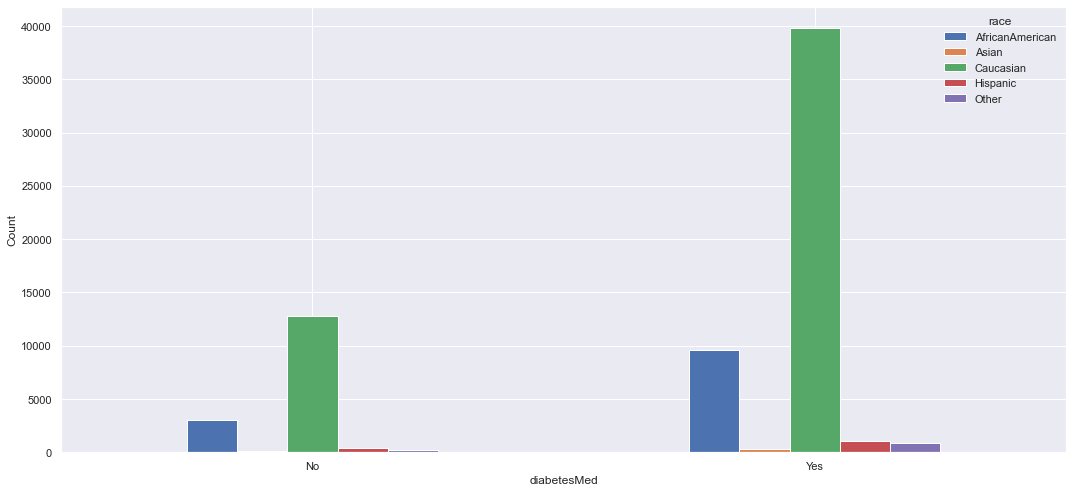

In [27]:
cont=pd.crosstab(df1["diabetesMed"], df1["race"])
print(cont)
barplot = cont.plot.bar(rot=0)
plt.ylabel("Count")

gender       Female   Male
diabetesMed               
No             9104   7465
Yes           27336  24452


Text(0, 0.5, 'Count')

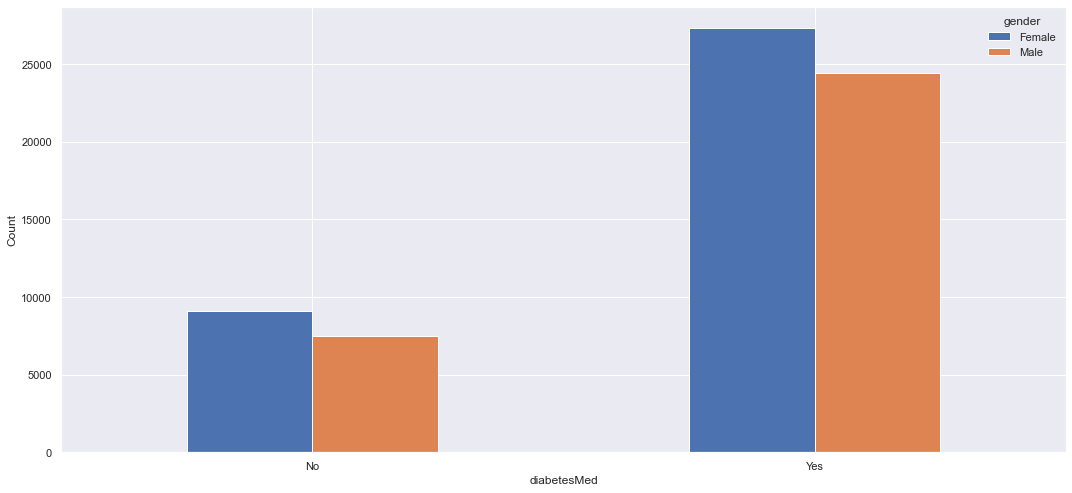

In [28]:
cont=pd.crosstab(df1["diabetesMed"], df1["gender"])
print(cont)
barplot = cont.plot.bar(rot=0)
plt.ylabel("Count")

gender           Female   Male
race                          
AfricanAmerican    7678   4933
Asian               243    240
Caucasian         27146  25492
Hispanic            790    679
Other               583    573


Text(0, 0.5, 'Count')

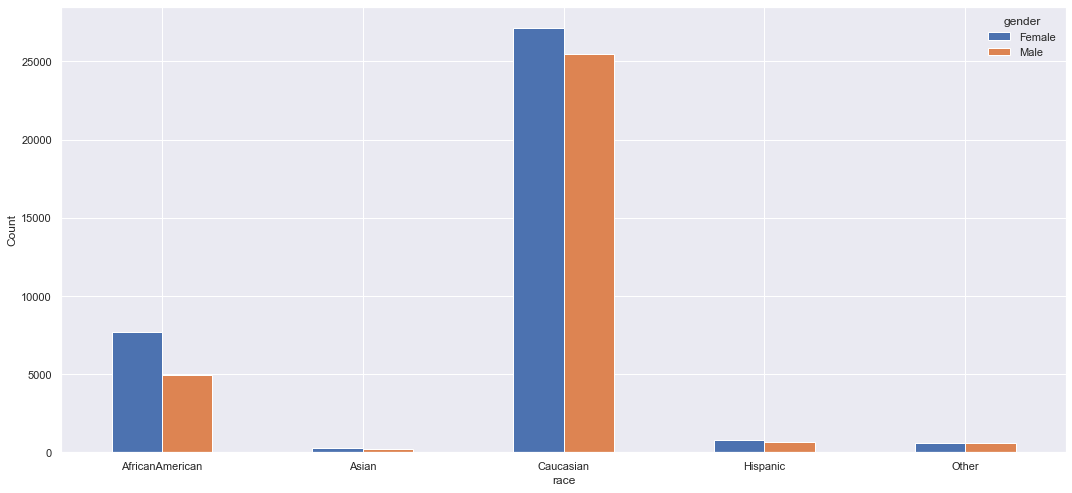

In [29]:
cont=pd.crosstab(df1["race"], df1["gender"])
print(cont)
barplot = cont.plot.bar(rot=0)
plt.ylabel("Count")

age              [0-10)  [10-20)  [20-30)  [30-40)  [40-50)  [50-60)  [60-70)  \
race                                                                            
AfricanAmerican       5      104      345      797     1829     2856     2803   
Asian                 1        0        5       10       42       90      116   
Caucasian            55      213      576     1506     4278     8461    11796   
Hispanic              1       17       48      134      224      310      337   
Other                 2        6       18       58      125      243      321   

age              [70-80)  [80-90)  [90-100)  
race                                         
AfricanAmerican     2471     1164       237  
Asian                141       68        10  
Caucasian          14445     9748      1560  
Hispanic             278      109        11  
Other                252      113        18  


Text(0, 0.5, 'Count')

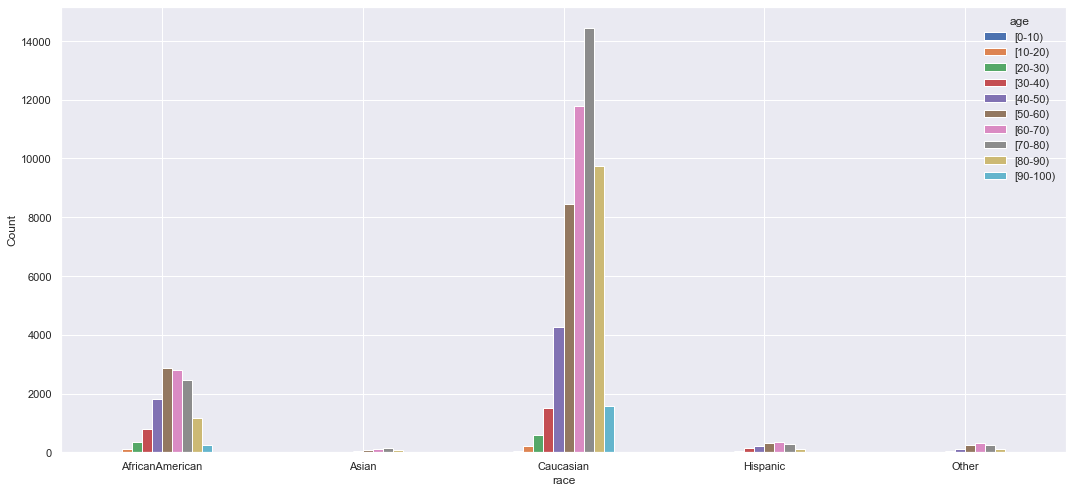

In [30]:
cont=pd.crosstab(df1["race"], df1["age"])
print(cont)
barplot = cont.plot.bar(rot=0)
plt.ylabel("Count")

age     [0-10)  [10-20)  [20-30)  [30-40)  [40-50)  [50-60)  [60-70)  [70-80)  \
gender                                                                          
Female      35      206      639     1464     3200     5821     7515     9431   
Male        29      134      353     1041     3298     6139     7858     8156   

age     [80-90)  [90-100)  
gender                     
Female     6833      1296  
Male       4369       540  


Text(0, 0.5, 'Count')

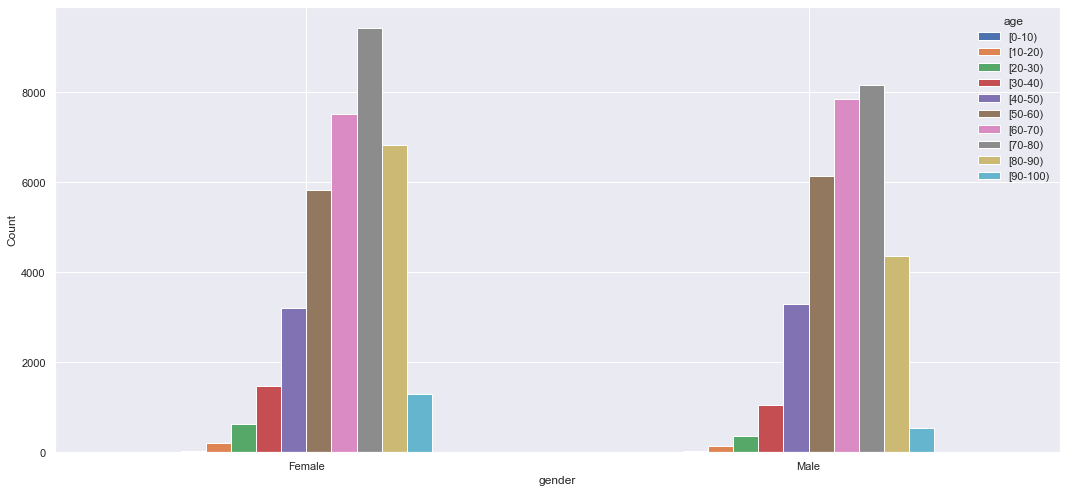

In [31]:
cont=pd.crosstab(df1["gender"], df1["age"])
print(cont)
barplot = cont.plot.bar(rot=0)
plt.ylabel("Count")

<AxesSubplot:xlabel='age', ylabel='readmitted'>

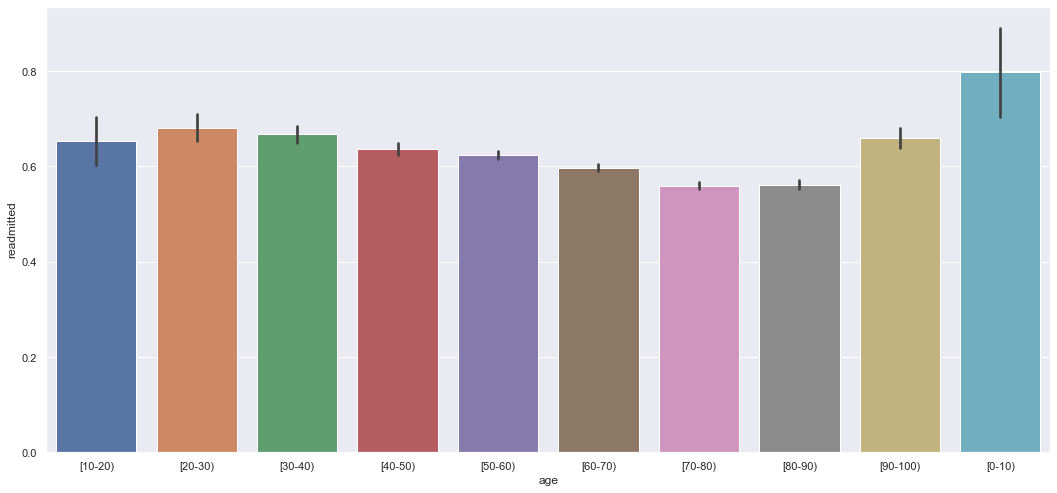

In [32]:
sns.barplot(data=df1, x="age", y="readmitted")

<AxesSubplot:xlabel='race', ylabel='time_in_hospital'>

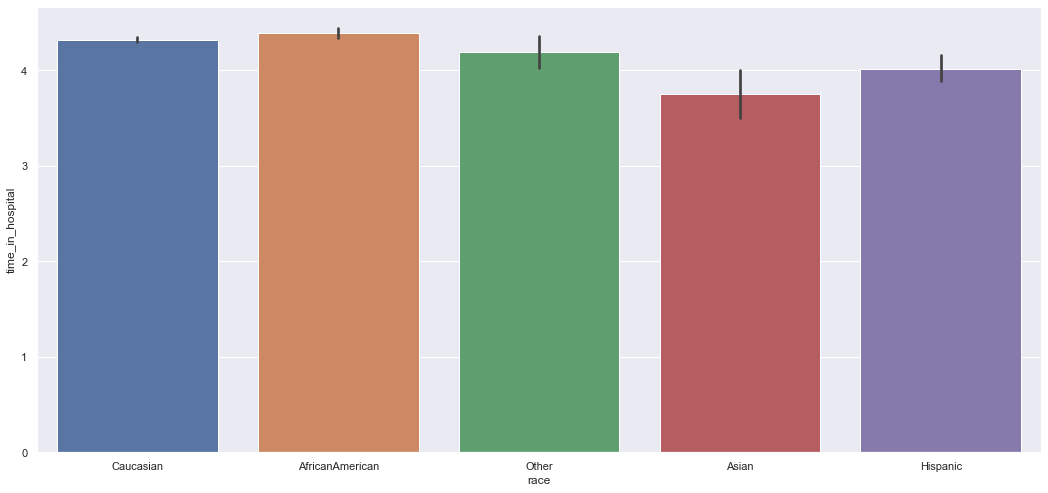

In [33]:
sns.barplot(data=df1, x="race", y="time_in_hospital")

<AxesSubplot:xlabel='gender', ylabel='time_in_hospital'>

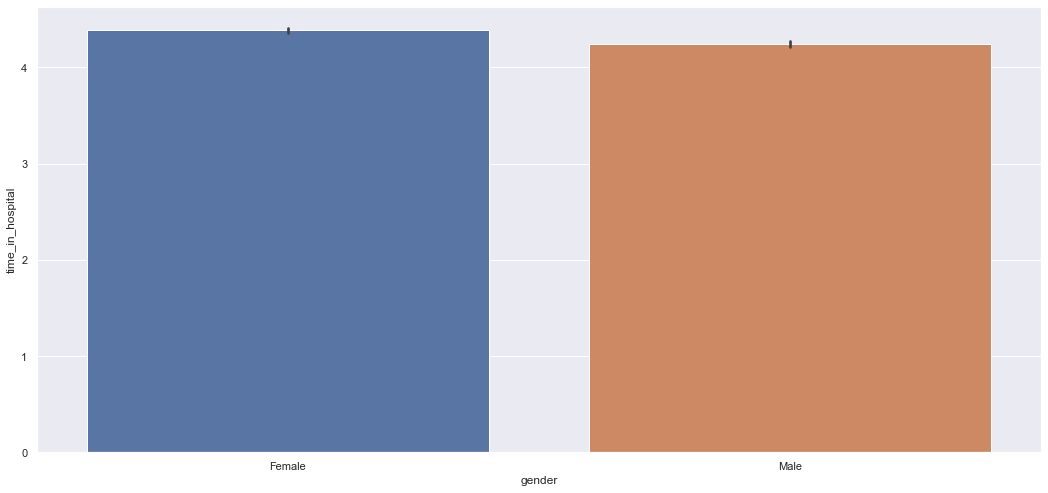

In [34]:
sns.barplot(data=df1, x="gender", y="time_in_hospital")

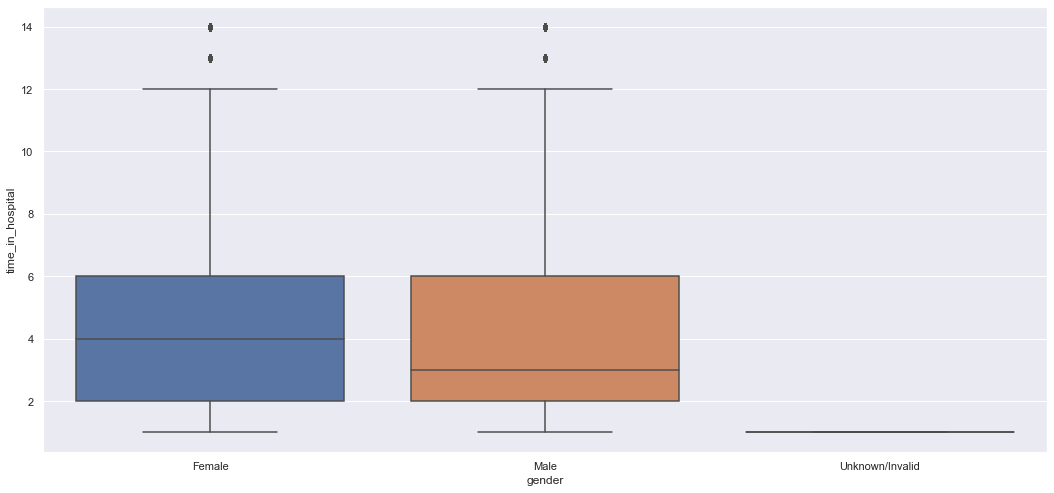

In [35]:
sns.boxplot(data = df, x = 'gender', y = 'time_in_hospital')
plt.show()

In [36]:
# Gender e time in hospital non sono variabili tra loro correlate. 

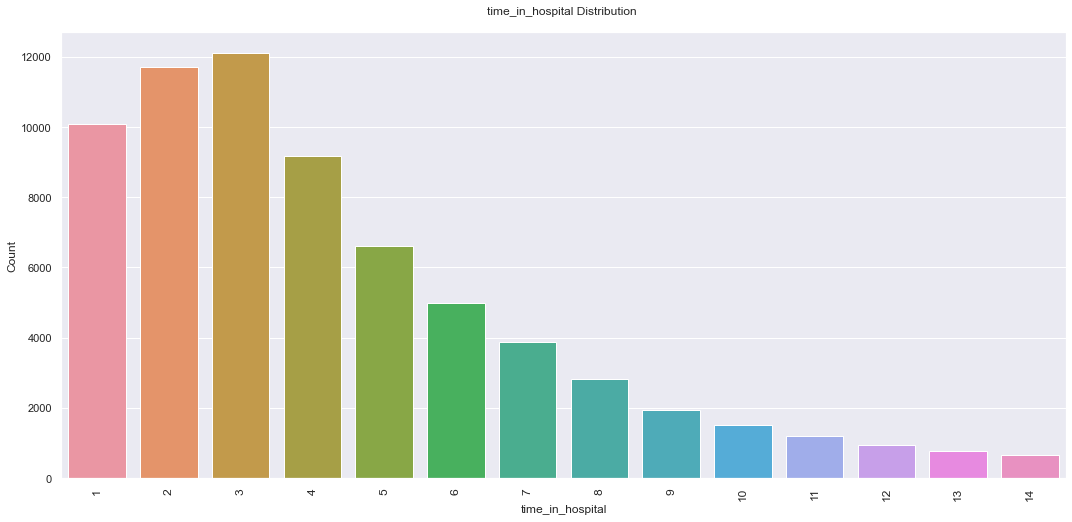

In [37]:
ax = sns.countplot(x='time_in_hospital',   data= df1)
plt.xlabel('time_in_hospital', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('time_in_hospital Distribution \n', size = 12)
plt.show()

<AxesSubplot:xlabel='time_in_hospital', ylabel='readmitted'>

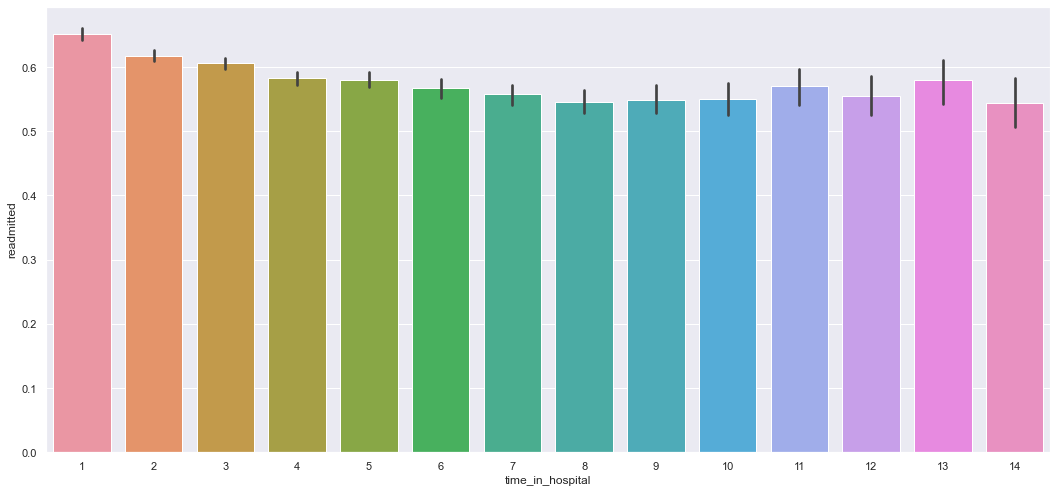

In [38]:
sns.barplot(data=df1, x="time_in_hospital", y="readmitted")

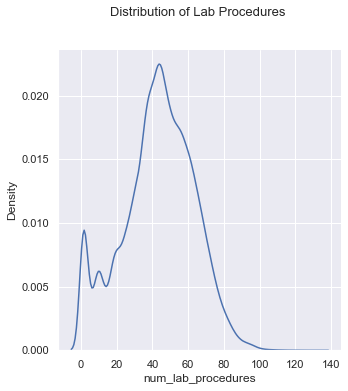

In [39]:
sns.displot(df, x="num_lab_procedures", kind="kde")
plt.title('Distribution of Lab Procedures \n\n', size = 13)
plt.show()

Vediamo se la distribuzione del numero 

Dal grafico si vede chiaramente che la distribuzione dei pazienti per la distribuzione del tempo in ospedale sia per i pazienti non riammessi che quelli riammessi 

In [ ]:
ax = sns.countplot(x='change',   data= df1)
plt.xlabel('change', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('change Distribution \n', size = 12)
plt.show()

In [ ]:
ax = sns.countplot(x='age',   data= df1)
plt.xlabel('Age', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('Age Distribution \n', size = 12)
plt.show()

In [ ]:
sns.barplot(data=df1, x="race", y="readmitted")

In [ ]:
sns.barplot(data=df1, x="gender", y="readmitted")

In [ ]:
sns.barplot(data=df1, x="age", y="readmitted")

## Medical Feature distribution

In [ ]:
list=['metformin','repaglinide', 'nateglinide' ,'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
      'rosiglitazone']



In [ ]:
for i in list:
    ax = sns.countplot(x=i,   data= df1)
    plt.xlabel(i, size = 12)
    plt.xticks(rotation=90, size = 12)
    plt.ylabel('Count', size = 12)
    plt.title(' Distribution \n', size = 12)
    plt.show()
    plt.figure()

ENCODING

Tutte le features mediche trasformarle in numeriche, idem insulin, idem change, idem diabetesMed. 

In [ ]:
#Cominciamo a fare l'encoding
# Ai fini della mia analisi encounter_id e patient_nbr non sono utili, quindi li elimino
df2=df1.copy()
df2.drop(['encounter_id','patient_nbr'],axis=1,inplace=True)
df2.head()

In [ ]:
ax = sns.countplot(x='insulin',   data= df1)
plt.xlabel('insulin', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('insulin Distribution \n', size = 12)
plt.show()

In [ ]:
ax = sns.countplot(x='acetohexamide',   data= df1)
plt.xlabel('acetohexamide', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('acetohexamide Distribution \n', size = 12)
plt.show()

In [ ]:
ax = sns.countplot(x='tolbutamide',   data= df1)
plt.xlabel('tolbutamide', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('tolbutamide Distribution \n', size = 12)
plt.show()

In [ ]:
ax = sns.countplot(x='troglitazone',   data= df1)
plt.xlabel('troglitazone', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('troglitazone Distribution \n', size = 12)
plt.show()

In [ ]:
ax = sns.countplot(x='tolazamide',   data= df1)
plt.xlabel('tolazamide', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('tolazamide Distribution \n', size = 12)
plt.show()

In [ ]:
ax = sns.countplot(x='examide',   data= df1)
plt.xlabel('examide', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('examide Distribution \n', size = 12)
plt.show()

In [ ]:
ax = sns.countplot(x='citoglipton',   data= df1)
plt.xlabel('citoglipton', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('citoglipton Distribution \n', size = 12)
plt.show()

In [ ]:
ax = sns.countplot(x='glipizide-metformin',   data= df1)
plt.xlabel('glipizide-metformin', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('glipizide-metformin Distribution \n', size = 12)
plt.show()

In [ ]:
ax = sns.countplot(x='glimepiride-pioglitazone',   data= df1)
plt.xlabel('glimepiride-pioglitazone', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('glimepiride-pioglitazone Distribution \n', size = 12)
plt.show()

In [ ]:
ax = sns.countplot(x='metformin-rosiglitazone',   data= df1)
plt.xlabel('metformin-rosiglitazone', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('metformin-rosiglitazone Distribution \n', size = 12)
plt.show()

In [ ]:
ax = sns.countplot(x='metformin-pioglitazone',   data= df1)
plt.xlabel('metformin-pioglitazone', size = 12)
plt.xticks(rotation=90, size = 12)
plt.ylabel('Count', size = 12)
plt.title('metformin-pioglitazone Distribution \n', size = 12)
plt.show()

In [ ]:
df2.drop(columns = ['acetohexamide', 'tolbutamide', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
                   'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                   'metformin-pioglitazone'], inplace = True)

In [ ]:
df2["race"]=df2["race"].replace(['AfricanAmerican','Hispanic','Other','Asian'],['NonCaucasian','NonCaucasian','NonCaucasian','NonCaucasian'])

In [ ]:
sns.barplot(data=df2, x="race", y="readmitted")

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()

In [ ]:
categorical_features =['race','gender','age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed'] 

for i in categorical_features:
    df2[i] = le.fit_transform(df2[i])

In [ ]:
df2.head()

# AIF360: Studio del sesso

0 indica le persone di sesso femminile, 1 indica le persone di sesso maschile 

In [ ]:
df3=df2.copy()

In [ ]:
data_orig_sex = BinaryLabelDataset(
    favorable_label=1, 
    unfavorable_label=0,
    df=df3, 
    label_names=['readmitted'], 
    protected_attribute_names=['gender'])

In [ ]:
np.random.seed(42)

data_orig_sex_train, data_orig_sex_test = data_orig_sex.split([0.7], shuffle=True)

display(Markdown("#### Train Dataset shape"))
print("Sex :",data_orig_sex_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print("Sex :",data_orig_sex_test.features.shape)

In [ ]:
rf_orig_sex = RandomForestClassifier().fit(data_orig_sex_train.features, 
                     data_orig_sex_train.labels.ravel(), 
                     sample_weight=data_orig_sex_train.instance_weights)

In [ ]:
X_test_sex = data_orig_sex_test.features
y_test_sex = data_orig_sex_test.labels.ravel()

In [ ]:
unprivileged_groups=[{'gender':0}]
privileged_groups=[{'gender':1}]
binary_metric=BinaryLabelDatasetMetric(data_orig_sex_test, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in disparate impact between unprivileged and privileged groups = %f" % binary_metric.disparate_impact())
print("Difference in statistical parity difference between unprivileged and privileged groups = %f" % binary_metric.statistical_parity_difference())


In [ ]:
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [ ]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [ ]:
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [ ]:
display(Markdown('### Bias metrics for the Sex model'))
fair = get_fair_metrics_and_plot(data_orig_sex_test, rf_orig_sex)

# AIF 360 race

In [ ]:
data_orig_race = BinaryLabelDataset(
    favorable_label=1, 
    unfavorable_label=0,
    df=df3, 
    label_names=['readmitted'], 
    protected_attribute_names=['race'])

In [ ]:
np.random.seed(42)

data_orig_race_train, data_orig_race_test = data_orig_race.split([0.7], shuffle=True)

display(Markdown("#### Train Dataset shape"))
print("Sex :",data_orig_race_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print("Sex :",data_orig_race_test.features.shape)

In [ ]:
rf_orig_race = RandomForestClassifier().fit(data_orig_race_train.features, 
                     data_orig_race_train.labels.ravel(), 
                     sample_weight=data_orig_race_train.instance_weights)

In [ ]:
X_test_race = data_orig_race_test.features
y_test_race = data_orig_race_test.labels.ravel()

In [ ]:
unprivileged_groups=[{'race':0}]
privileged_groups=[{'race':1}]
binary_metric=BinaryLabelDatasetMetric(data_orig_race_test, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in disparate impact between unprivileged and privileged groups = %f" % binary_metric.disparate_impact())
print("Difference in statistical parity difference between unprivileged and privileged groups = %f" % binary_metric.statistical_parity_difference())


In [ ]:
display(Markdown('### Bias metrics for the Race model'))
fair = get_fair_metrics_and_plot(data_orig_race_test, rf_orig_race)